## Train a cellpose 2D model 

Before running this notebook a set of patches must exist in the following format.

1.  Ground Truth are put in a directory called ```/ground truth0```
2.  Inputs are put in a directory called ```inputn``` where n is an integer 0...m and represents the channel.  Note:  RGB images may only have one 'channel' directory.
3.  In each of the both directories there exist a set of files of the same names.  For example if in the ```inputn``` directory we have ```apples0```, ```apples1```, ```apples2``` label images of the same name must exist in the ```ground truth``` directory.  

In [1]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
from cellpose import models, io
from pathlib import Path
from tnia.deeplearning.dl_helper import collect_training_data, divide_training_data



Welcome to CellposeSAM, cellpose v4.0.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [2]:
tnia_images_path = Path(r"D:\images")
parent_path = r'D:\images\tnia-python-images\imagesc\2024_12_19_sem_grain_size_revisit'
train_path = os.path.join(parent_path, 'patches')
#train_path = os.path.join(parent_path, 'labels')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

# for cellpose no need for 'models' in model path name because it is auto added
model_path = parent_path

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

## Use a helper to collect the training data

The helper will also normalize the inputs.

In [3]:
X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel=False, relabel=True)


print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)

  0%|          | 0/680 [00:00<?, ?it/s]C:\Users\bnort\work\ImageJ2022\tnia\tnia-python\tnia\deeplearning\dl_helper.py:429: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  input_img = io.imread(os.path.join(input_path, input_files[i]), plugin='tifffile')
C:\Users\bnort\work\ImageJ2022\tnia\tnia-python\tnia\deeplearning\dl_helper.py:430: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  ground_truth_img = io.imread(os.path.join(truth_path, truth_files[i]), plugin='tifffile')
C:\Users\bnort\work\Im

Number of input images 680
Number of ground truth images  680
Size of first input image (512, 512)
Size of first ground truth image  (512, 512)


## Experimental fill holes

In [5]:
len(X), len(Y)

X = X[0:50]
Y = Y[0:50]

In [6]:
from tqdm import tqdm
from tnia.morphology.fill_holes import fill_holes

for n in tqdm(range(len(Y)), desc="Filling Holes"):
    Y[n] = fill_holes(Y[n], area_threshold=10000)

Filling Holes: 100%|██████████| 50/50 [00:04<00:00, 10.38it/s]


## Divide into training and validation sets

Unlike stardist Cellpose does not seem to need numpy arrays as input.  So to create training and validation sets we can simply split the X and Y vectors. 

In [7]:
X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, 2, to_numpy=False)

print('Number of training images', len(X_train))
print('Number of validaiton images ', len(X_val))


Number of training images 48
Number of validaiton images  2


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

(512, 512) (512, 512)
0.060709793 0.8693235
float32 (512, 512) 0.060709793 0.8693235


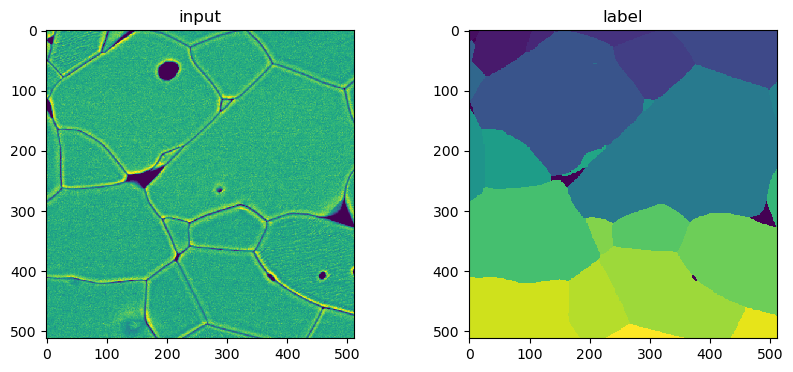

In [8]:
n=0
X_ = X_train[n]
Y_ = Y_train[n]

X_ = X[0]
Y_ = Y[0]

print(X_.shape, Y_.shape)
print(X_.min(), X_.max())
print(X_.dtype, X_.shape, X_.min(), X_.max())
fig=imshow_multi2d([X_, Y_], ['input', 'label'], 1,2)

## Create a cellpose model

In [9]:
import os

model_name = 'cellpose_grains_fill_holes'

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL
#model= models.CellposeModel(gpu=True, pretrained_model=os.path.join(model_path,'models',model_name))
model= models.CellposeModel(gpu=True)
#model= models.CellposeModel(gpu=True, pretrained_model=None) #os.path.join(model_path,'models',model_name))

2025-05-11 07:46:44,260 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2025-05-11 07:46:44,261 [INFO] 
cellpose version: 	4.0.1 
platform:       	win32 
python version: 	3.11.12 
torch version:  	2.6.0
2025-05-11 07:46:44,602 [INFO] ** TORCH CUDA version installed and working. **
2025-05-11 07:46:44,603 [INFO] >>>> using GPU (CUDA)
2025-05-11 07:46:46,531 [INFO] >>>> loading model C:\Users\bnort\.cellpose\models\cpsam


# Train the model

In [10]:
from cellpose import train

new_model_path = train.train_seg(model.net, X_train, Y_train, test_data=X_val, test_labels=Y_val,  
                              #channels=[0,0], 
                              save_path=model_path, 
                              n_epochs=10,
                              min_train_masks=0,
                              rescale = False,  
                              model_name=model_name,
                              normalize=False)
                              #bsize=512)

2025-05-11 07:46:57,473 [INFO] computing flows for labels


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]

2025-05-11 07:47:20,148 [INFO] computing flows for labels



100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

2025-05-11 07:47:21,045 [INFO] >>> computing diameters



  0%|          | 0/48 [00:00<?, ?it/s]c:\Users\bnort\miniconda3\envs\microsam_cellose_sam\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bnort\miniconda3\envs\microsam_cellose_sam\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2/2 [00:00<00:00, 666.61it/s]

2025-05-11 07:47:21,203 [INFO] >>> n_epochs=10, n_train=48, n_test=2
2025-05-11 07:47:21,204 [INFO] >>> AdamW, learning_rate=0.00005, weight_decay=0.10000
2025-05-11 07:47:21,232 [INFO] >>> saving model to D:\images\tnia-python-images\imagesc\2024_12_19_sem_grain_size_revisit\models\cellpose_grains_fill_holes


2025-05-11 07:47:34,740 [INFO] 0, train_loss=3.9799, test_loss=0.7333, LR=0.000000, time 13.53s
2025-05-11 07:48:33,146 [INFO] 5, train_loss=1.7809, test_loss=0.6939, LR=0.000028, time 71.94s
2025-05-11 07:49:19,908 [INFO] saving network parameters to D:\images\tnia-python-images\imagesc\2024_12_19_sem_grain_size_revisit\models\cellpose_grains_fill_holes


## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

2025-05-11 07:49:50,062 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-05-11 07:49:52,179 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-05-11 07:49:53,733 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


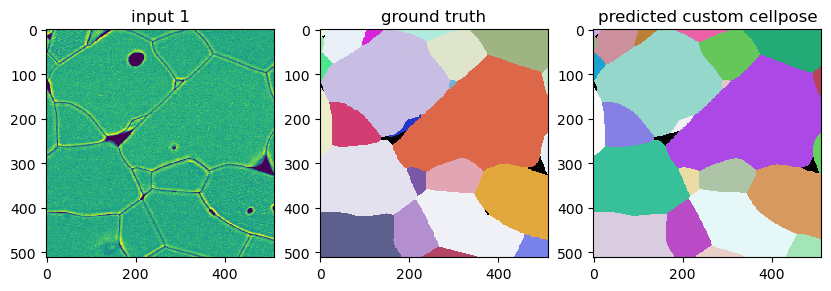

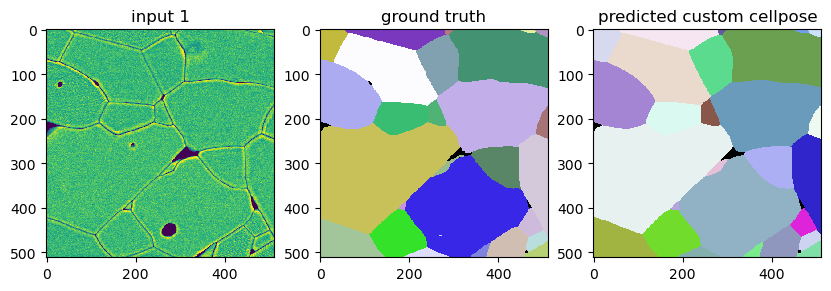

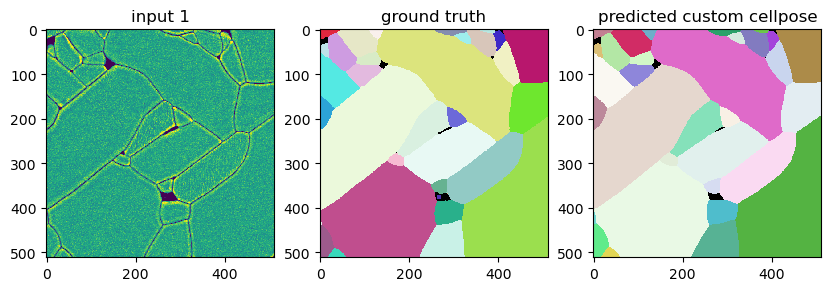

In [12]:
from tnia.plotting.plt_helper import random_label_cmap
# run model on test images

num = 3

for n in range(num):
    #masks = model.eval(X[n], channels=[0,0], bsize=512, niter=2000, cellprob_threshold=-4, flow_threshold=-4)
    masks = model.eval(X[n], channels=[0,0], niter=2000)
    fig = imshow_multi2d([X[n], Y[n], masks[0]],['input 1','ground truth','predicted custom cellpose'],1,3,colormaps=[None,random_label_cmap(),random_label_cmap()])


## View in Napari

In [12]:
import napari
import pandas as pd

points = pd.read_csv(parent_path / 'Results.csv')
viewer = napari.Viewer()
viewer.add_image(testim, name='testim')
viewer.add_labels(labels, name='labels')
viewer.add_labels(labels_cyto2, name='labels_cyto2')
points_layer = viewer.add_points(points[['Y', 'X']], size=4, face_color='blue', name='points')